# Sentimental Analysis
## Recurrent Neural Networks (RNN)

**PURPOSE:** Classify if a Tweet (text) is positive or negative.<br><br>
Inspiration: https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

Data Source: https://data.world/smartdevil33/sentiment-analysis/

In [1]:
# Import TensorFlow
%tensorflow_version 2.x
import tensorflow as tf

# Import Keras
from tensorflow import keras

# Allows us to work with files and folders
import os

print('Version: ', tf.__version__)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

TensorFlow 2.x selected.
Version:  2.1.0
GPU is available


In [0]:
# Load all necessary libraries
from tensorflow.keras import layers
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, Input, Flatten, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# To split the training and test data
from sklearn.model_selection import train_test_split

# To manipulate the data and organize
import pandas as pd
import numpy as np
from numpy import array
import re

# For visualization purposes
import matplotlib.pyplot as plt

In [3]:
# Allows us to work with Files
from google.colab import files

# To unzip our ZIP file
import zipfile

# Connects to GoogleDrive
from google.colab import drive

drive.mount('/content/drive')



Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Unzip the data and save it in another folder
local_zip = '/content/drive/My Drive/Colab Notebooks/text_emotion.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Sentiment-Analysis')
print('ZIP files extracted!')
zip_ref.close()

ZIP files extracted!


In [5]:
#import pandas as pd

# Read data
text_emotion = pd.read_csv('Sentiment-Analysis/text_emotion.csv')

print('The shape of the dataframe is:', text_emotion.shape)
text_emotion.head()

The shape of the dataframe is: (40000, 4)


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


## Prepare the text data

In [6]:
# Find NAs
text_emotion.isna().sum()
#text_emotion = text_emotion.dropna()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

In [7]:
# Find unique values in the sentiment column
text_emotion.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [8]:
# View amount of unique values in each column
text_emotion['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [0]:
# negative = 1
# positive = 0
temp = text_emotion.sentiment.fillna("0")

# Simplification
# Classify sentiment variables as 0 (positive) or 1 (negative)
text_emotion['sentiment'] = np.where(temp.str.contains("empty"), 1,
                            np.where(temp.str.contains("sadness"), 1,
                            np.where(temp.str.contains("neutral"), 1,
                            np.where(temp.str.contains("enthusiasm"), 0,
                            np.where(temp.str.contains("worry"), 1,
                            np.where(temp.str.contains("surprise"), 0,
                            np.where(temp.str.contains("love"), 0,
                            np.where(temp.str.contains("fun"), 0,
                            np.where(temp.str.contains("hate"), 1,
                            np.where(temp.str.contains("happiness"), 0,
                            np.where(temp.str.contains("boredom"), 1,
                            np.where(temp.str.contains("relief"), 1,
                            np.where(temp.str.contains("anger"), 1, 0)))))))))))))

In [10]:
text_emotion.head()

,tweet_id,sentiment,author,content
0,1956967341,1,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,1,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,1,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,0,czareaquino,wants to hang out with friends SOON!
4,1956968416,1,xkilljoyx,@dannycastillo We want to trade with someone w...


In [11]:
# TOTAL POSITIVE SENTIMENTS
print('Total positive sentiments:', len(text_emotion) - text_emotion['sentiment'].values.sum())

# TOTAL NEGATIVE SENTIMENTS
print('Total negative sentiments:', text_emotion['sentiment'].values.sum())

# TOTAL AMOUNT
print('\nTotal amount:', len(text_emotion))

Total positive sentiments: 13773
Total negative sentiments: 26227

Total amount: 40000


In [0]:
# Change sentiment column to negative (neg) or positive (pos)
text_emotion.loc[text_emotion['sentiment'] == 1, 'sentiment'] = 'neg'
text_emotion.loc[text_emotion['sentiment'] == 0, 'sentiment'] = 'pos'

# Keep sentiment score and name columns for visualization only
#data['sentiment-value'] = ['pos' if (x==0) else 'neg' for x in data['sentiment']]
# Then change 'sentiment' in the creation of the Y variable

In [0]:
# Convert tweet_id column to Index
text_emotion.set_index('tweet_id', inplace = True)

In [14]:
text_emotion.head()

,sentiment,author,content
tweet_id,,,
1956967341,neg,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1956967666,neg,wannamama,Layin n bed with a headache ughhhh...waitin o...
1956967696,neg,coolfunky,Funeral ceremony...gloomy friday...
1956967789,pos,czareaquino,wants to hang out with friends SOON!
1956968416,neg,xkilljoyx,@dannycastillo We want to trade with someone w...


In [15]:
# Verify that the data types are acceptable
text_emotion.dtypes

sentiment    object
author       object
content      object
dtype: object

## Vectorizing the text

In [16]:
# Prepare tokinzer / vectorization of the string data
tokenizer = Tokenizer(nb_words = 2000, 
                      filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower = True, 
                      split = ' ')

# Tokenize the 'content' string data
tokenizer.fit_on_texts(text_emotion['content'].values)

/tensorflow-2.1.0/python3.6/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [17]:
# View tokenized words (dictionary)
print(tokenizer.word_index)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'it': 8, 'is': 9, 'in': 10, 'for': 11, 'of': 12, 'me': 13, 'on': 14, 'have': 15, 'so': 16, 'that': 17, 'but': 18, 'just': 19, "i'm": 20, 'day': 21, 'with': 22, 'be': 23, 'at': 24, 'was': 25, 'not': 26, 'good': 27, 'all': 28, 'this': 29, 'now': 30, 'out': 31, 'up': 32, 'get': 33, 'like': 34, 'no': 35, 'are': 36, 'quot': 37, 'http': 38, 'go': 39, "it's": 40, 'do': 41, 'your': 42, 'today': 43, 'love': 44, 'work': 45, 'got': 46, 'too': 47, 'going': 48, 'happy': 49, 'lol': 50, 'from': 51, 'one': 52, 'time': 53, 'u': 54, 'know': 55, 'back': 56, 'what': 57, 'com': 58, 'im': 59, 'will': 60, 'really': 61, 'we': 62, 'am': 63, 'about': 64, "don't": 65, 'its': 66, 'see': 67, 'amp': 68, 'there': 69, 'had': 70, 'can': 71, "can't": 72, 'some': 73, 'if': 74, 'night': 75, 'new': 76, 'home': 77, 'think': 78, 'well': 79, '2': 80, 'thanks': 81, 'when': 82, 'want': 83, 'as': 84, 'how': 85, 'oh': 86, 'still': 87, 'off': 88, 'much': 89, 'they':

In [0]:
# Create X variable
X = tokenizer.texts_to_sequences(text_emotion['content'].values)

# Transform data into 2D numpy arrays to fit shapes
X = pad_sequences(X)

In [19]:
text_emotion.head()

,sentiment,author,content
tweet_id,,,
1956967341,neg,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1956967666,neg,wannamama,Layin n bed with a headache ughhhh...waitin o...
1956967696,neg,coolfunky,Funeral ceremony...gloomy friday...
1956967789,pos,czareaquino,wants to hang out with friends SOON!
1956968416,neg,xkilljoyx,@dannycastillo We want to trade with someone w...


In [20]:
len(text_emotion)

40000

## Build the Neural Network

In [21]:
embed_dim = 128
lstm_out = 196
batch_size = 32

# Build model
model = Sequential()

# FIRST LAYER
# Embedding Layer
model.add(Embedding(2000, 
                    embed_dim,
                    input_length = X.shape[1]))

# DROPOUT LAYER (mostly used when model is overfitting)
#model.add(Dropout(0.2))

# LSTM Layer
model.add(LSTM(lstm_out,))
               #dropout = 0.2,  # Fraction of the units to drop for the linear transformation of the inputs
               #recurrent_dropout = 0.2))  # Fraction of the units to drop for the linear transformation of the recurrent state

# ANOTHER HIDDEN LAYER (added to help the model fit better)
model.add(Dense(16, 
                activation='relu'))  # relu: output greater than or equal to 0

# OUTPUT LAYER
# 2 outputs for 0 (positive) or 1 (negative)
model.add(Dense(2,
                activation = 'softmax'))  
                # sigmoid: float between 0 and 1, representing a probability, or confidence level
                # softmax: all values are non-negative and sum to 1 (mostly used in multi-class classification problems)

# COMPILE THE MODEL
# Load Optimizer
from tensorflow.keras.optimizers import Adam
# Customize Optimizer
adam = Adam(lr=0.0001)
# Add Loss, Optimizer and Metrics to Model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = adam,  # 'adam'
              metrics = ['accuracy'])

# SUMMARY OF THE MODEL
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 128)           256000    
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 16)                3152      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 513,986
Trainable params: 513,986
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# Create Y variable
Y = pd.get_dummies(text_emotion['sentiment']).values

# Splitting the data (training and test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)  # Random Seed

# View the shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(32000, 35) (32000, 2)
(8000, 35) (8000, 2)


In [23]:
# Sneak peek
X_train

array([[   0,    0,    0, ...,    0,  841, 1251],
       [   0,    0,    0, ...,    8,   22,    3],
       [   0,    0,    0, ...,   24,  350,  119],
       ...,
       [   0,    0,    0, ...,   66,  551,  364],
       [   0,    0,    0, ...,   10,  120,  406],
       [   0,    0,    0, ...,   93,   53,  515]], dtype=int32)

In [24]:
# Sneak peek
Y_train

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

### Visualize the Neural Network

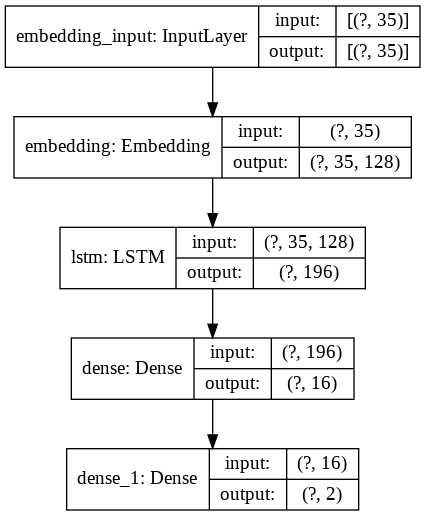

In [25]:
# Visualize the Neural Network
tf.keras.utils.plot_model(
    model,
    to_file = 'model-visualization.png',
    show_shapes = True,
    show_layer_names = True,
    rankdir = 'TB',
    expand_nested = False,
    dpi = 96)

## Fit the model

In [26]:
# Train the model with the training data
trained_model = model.fit(X_train, Y_train, 
                    batch_size = batch_size,
                    epochs = 10, 
                    verbose = 2,
                    validation_split = 0.2)

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 - 70s - loss: 0.6194 - accuracy: 0.6677 - val_loss: 0.5592 - val_accuracy: 0.7214
Epoch 2/10
25600/25600 - 65s - loss: 0.5287 - accuracy: 0.7452 - val_loss: 0.5525 - val_accuracy: 0.7300
Epoch 3/10
25600/25600 - 66s - loss: 0.5064 - accuracy: 0.7589 - val_loss: 0.5455 - val_accuracy: 0.7370
Epoch 4/10
25600/25600 - 66s - loss: 0.4974 - accuracy: 0.7646 - val_loss: 0.5417 - val_accuracy: 0.7331
Epoch 5/10
25600/25600 - 65s - loss: 0.4908 - accuracy: 0.7681 - val_loss: 0.5444 - val_accuracy: 0.7341
Epoch 6/10
25600/25600 - 65s - loss: 0.4854 - accuracy: 0.7738 - val_loss: 0.5435 - val_accuracy: 0.7298
Epoch 7/10
25600/25600 - 64s - loss: 0.4812 - accuracy: 0.7753 - val_loss: 0.5489 - val_accuracy: 0.7361
Epoch 8/10
25600/25600 - 63s - loss: 0.4753 - accuracy: 0.7790 - val_loss: 0.5487 - val_accuracy: 0.7381
Epoch 9/10
25600/25600 - 64s - loss: 0.4700 - accuracy: 0.7830 - val_loss: 0.5521 - val_accuracy: 0.7247
Epoch 

**Note:** The Validation Loss seems to not change much, regardless of adding/removing a Dropout and/or a Hidden Layer... 🤔

In [27]:
# Evaluate the Model
score, acc = model.evaluate(X_test, Y_test,  # Test data
                           verbose = 2, 
                           batch_size = batch_size)

# View Score and Accuracy of the model
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

8000/8000 - 6s - loss: 0.5703 - accuracy: 0.7303
Score: 0.57
Validation Accuracy: 0.73


### Visualize the Accuracy & Loss

<Figure size 432x288 with 0 Axes>

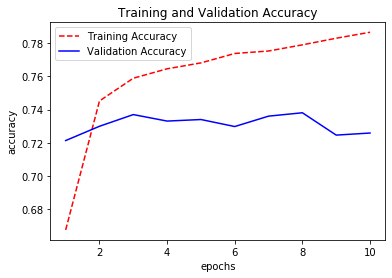

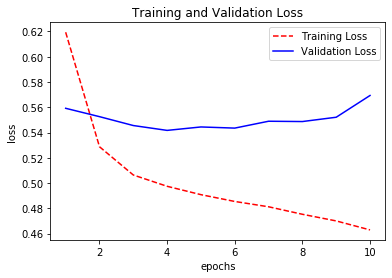

<Figure size 432x288 with 0 Axes>

In [28]:
# Get Accuracy and Loss values from the trained model
acc = trained_model.history['accuracy']
validation_acc = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
validation_loss = trained_model.history['val_loss']

# Get number of epochs used in the model
epochs = range(1, len(acc) + 1, 1)

plt.plot(epochs, acc, 'r--', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()

## Save the model

In [0]:
import time, os, fnmatch, shutil

# Save model as h5 with timestamp
if os.path.exists('MyNetwork_Sentimental Analysis.h5'):
  t = time.localtime()
  timestamp = time.strftime('%b-%d-%Y_%H%M', t)
  model.save('MyNetwork_Sentimental Analysis_{}.h5'.format(timestamp))
  print('Model saved on:', timestamp)
else:
  model.save('MyNetwork_Sentimental Analysis.h5')